[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/DifferentiableUniverseInitiative/jaxDecomp/blob/main/examples/demo_features.ipynb)

# jaxDecomp Feature Demo

`jaxDecomp` is a JAX library for **3D domain decomposition** and **parallel FFTs** on distributed systems. It provides:

- `pfft3d` / `pifft3d` — distributed 3D FFTs with automatic data transposes
- `halo_exchange` — ghost-cell communication for stencil operations
- Transpose operations — explicit pencil-to-pencil layout changes
- `fftfreq3d` — frequency-space coordinate vectors

All operations are **JAX primitives** and compose with `jax.jit`, `jax.grad`, and `jax.vmap`.

This notebook simulates 8 CPU devices locally to demonstrate distributed functionality.

In [1]:
#!pip install -q jaxdecomp matplotlib

In [2]:
import os

os.environ['XLA_FLAGS'] = '--xla_force_host_platform_device_count=8'
os.environ['JAX_PLATFORM_NAME'] = 'cpu'
os.environ['JAX_PLATFORMS'] = 'cpu'

In [3]:
from functools import partial

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax.sharding import AxisType, NamedSharding
from jax.sharding import PartitionSpec as P

import jaxdecomp as jdp

# Create a pencil mesh (4x2 = 8 devices, shards both axes)
pencil_mesh = jax.make_mesh(
    (4, 2),
    ('z', 'y'),
    axis_types=(AxisType.Auto, AxisType.Auto),
)

# Create a slab mesh (8x1 = 8 devices, shards first axis only)
slab_mesh = jax.make_mesh(
    (8, 1),
    ('z', 'y'),
    axis_types=(AxisType.Auto, AxisType.Auto),
)

print(f'Running on {jax.device_count()} devices')
print(f'Pencil mesh shape: {pencil_mesh.shape}')
print(f'Slab mesh shape:   {slab_mesh.shape}')

Running on 8 devices
Pencil mesh shape: OrderedDict([('z', 4), ('y', 2)])
Slab mesh shape:   OrderedDict([('z', 8), ('y', 1)])


## Decomposition Types

jaxDecomp supports different domain decomposition strategies controlled by the mesh's `pdims`:

| pdims | Type | Description |
|-------|------|-------------|
| `(1, 1)` | `NO_DECOMP` | No decomposition (single device) |
| `(px, 1)` | `SLAB_XY` | Shard only the first axis |
| `(1, py)` | `SLAB_YZ` | Shard only the second axis |
| `(px, py)` | `PENCILS` | Shard both axes (most scalable) |

**Slab** decomposition splits the domain into slabs along one axis. **Pencil** decomposition splits along two axes, yielding "pencil"-shaped sub-domains. Pencil decomposition scales to more devices but requires two transpose steps for a full 3D FFT instead of one.

In [4]:
# Global array shape
global_shape = (64, 128, 256)

# Create a sharded array with pencil decomposition
pencil_sharding = NamedSharding(pencil_mesh, P('z', 'y'))
key = jax.random.PRNGKey(42)
x = jax.device_put(jax.random.normal(key, global_shape), pencil_sharding)

print('Pencil-sharded array shape:', x.shape)
print('\nPencil sharding (4x2 grid):')
jax.debug.visualize_array_sharding(x[..., 0])

# Create a sharded array with slab decomposition
slab_sharding = NamedSharding(slab_mesh, P('z', 'y'))
x_slab = jax.device_put(jax.random.normal(key, global_shape), slab_sharding)

print('\nSlab-sharded array shape:', x_slab.shape)
print('\nSlab sharding (8x1 slabs):')
jax.debug.visualize_array_sharding(x_slab[..., 0])

Pencil-sharded array shape: (64, 128, 256)

Pencil sharding (4x2 grid):


                                                  
          CPU 0                    CPU 1          
                                                  
                                                  
          CPU 2                    CPU 3          
                                                  
                                                  
          CPU 4                    CPU 5          
                                                  
                                                  
          CPU 6                    CPU 7          
                                                  


Slab-sharded array shape: (64, 128, 256)

Slab sharding (8x1 slabs):


                      CPU 0                       
                                                  
                      CPU 1                       
                                                  
                      CPU 2                       
                                                  
                      CPU 3                       
                                                  
                      CPU 4                       
                                                  
                      CPU 5                       
                                                  
                      CPU 6                       
                                                  
                      CPU 7                       
                                                  

## Distributed 3D FFT

`pfft3d` computes a distributed 3D FFT. It performs local FFTs on each shard and uses `all_to_all` transposes to redistribute data between axes.

**Important:** The output shape is **transposed** relative to the input. An input of shape `(X, Y, Z)` produces output of shape `(Y, Z, X)`. This is because the data must be rearranged across devices during the FFT.

`pifft3d` computes the inverse, restoring the original shape.

In [5]:
# Forward FFT on pencil-sharded array
k = jdp.pfft3d(x)

print(f'Input shape:  {x.shape}')
print(f'Output shape: {k.shape}  (transposed: X,Y,Z -> Y,Z,X)')
print(f'Output dtype: {k.dtype}')

print('\nFFT output sharding:')
jax.debug.visualize_array_sharding(k[..., 0])

# You can also programmatically get the expected output sharding
out_sharding = jdp.get_fft_output_sharding(pencil_sharding)
print(f'\nExpected output PartitionSpec: {out_sharding.spec}')

Input shape:  (64, 128, 256)
Output shape: (128, 256, 64)  (transposed: X,Y,Z -> Y,Z,X)
Output dtype: complex64

FFT output sharding:


                                                  
          CPU 0                    CPU 1          
                                                  
                                                  
          CPU 2                    CPU 3          
                                                  
                                                  
          CPU 4                    CPU 5          
                                                  
                                                  
          CPU 6                    CPU 7          
                                                  


Expected output PartitionSpec: PartitionSpec('z', 'y', None)


In [6]:
# Inverse FFT: recover the original array
x_rec = jdp.pifft3d(k)

print(f'Reconstructed shape: {x_rec.shape}  (matches original: {x_rec.shape == x.shape})')

# Verify round-trip correctness
is_close = jnp.allclose(x, x_rec.real, atol=1e-5)
print(f'Round-trip FFT -> IFFT allclose: {is_close}')

Reconstructed shape: (64, 128, 256)  (matches original: True)
Round-trip FFT -> IFFT allclose: True


In [7]:
# FFT with slab decomposition for comparison
k_slab = jdp.pfft3d(x_slab)

print(f'Slab input shape:  {x_slab.shape}')
print(f'Slab output shape: {k_slab.shape}')

print('\nSlab FFT output sharding (data redistributed along second axis):')
jax.debug.visualize_array_sharding(k_slab[..., 0])

Slab input shape:  (64, 128, 256)
Slab output shape: (128, 256, 64)

Slab FFT output sharding (data redistributed along second axis):


                                                                        
                                                                        
                                                                        
                                                                        
                                                                        
  CPU 0    CPU 1    CPU 2    CPU 3    CPU 4    CPU 5    CPU 6    CPU 7  
                                                                        
                                                                        
                                                                        
                                                                        
                                                                        

## Frequency Vectors

`fftfreq3d` computes the frequency-space coordinate vectors from an FFT output array. This is essential for spectral methods (e.g., computing derivatives, filtering, or power spectra in Fourier space).

It returns three arrays `(kz, ky, kx)` broadcast to match the FFT output shape.

In [8]:
# Compute frequency vectors from FFT output
kz, ky, kx = jdp.fftfreq3d(k)

print(f'kz shape: {kz.shape}')
print(f'ky shape: {ky.shape}')
print(f'kx shape: {kx.shape}')

# Compute |k|^2 (useful for power spectrum, Laplacian in spectral space)
k_squared = kx**2 + ky**2 + kz**2
print(f'\n|k|^2 shape: {k_squared.shape}')
print(f'|k|^2 min: {k_squared.min():.4f}, max: {k_squared.max():.4f}')

kz shape: (1, 1, 64)
ky shape: (128, 1, 1)
kx shape: (1, 256, 1)

|k|^2 shape: (128, 256, 64)
|k|^2 min: 0.0000, max: 29.6088


## Halo Exchange

Halo exchange communicates **ghost cells** between neighboring shards. This is needed for stencil operations (finite differences, convolutions) that access neighboring grid points across shard boundaries.

The workflow is:
1. **Pad** each shard locally using `shard_map` to add halo regions
2. **Exchange** the halo data between neighbors with `halo_exchange`

Parameters:
- `halo_extents`: tuple of ints, one per sharded dimension (how many ghost cells)
- `halo_periods`: tuple of bools (whether to wrap around at domain boundaries)

Original shape:  (64, 128, 256)
Padded shape:    (96, 144, 256)
Exchanged shape: (96, 144, 256)


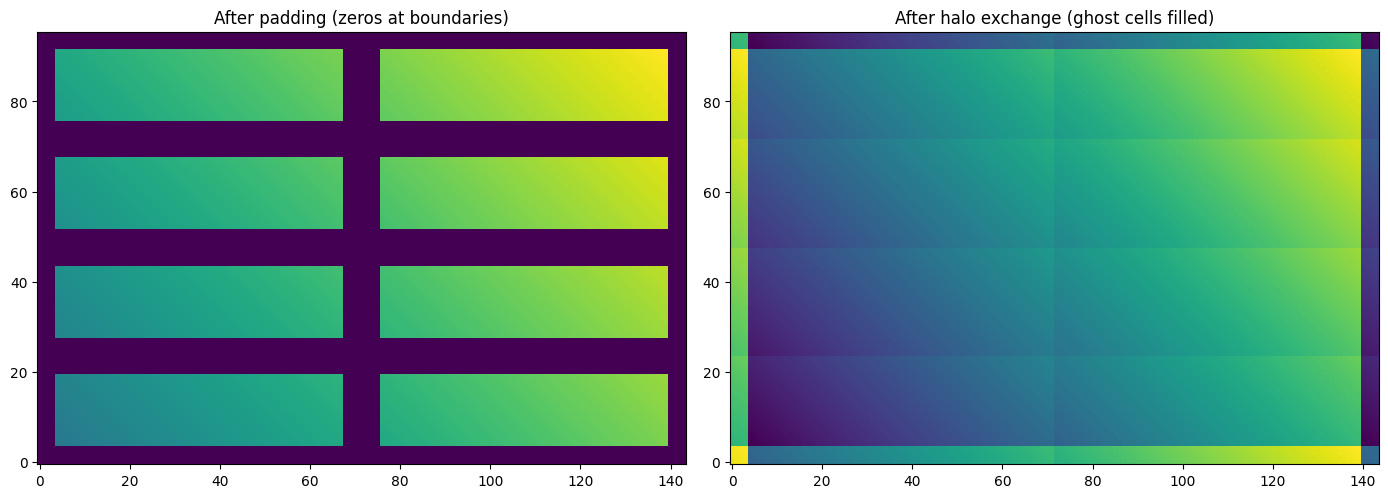

In [9]:
from jax import shard_map

halo_size = 4
halo_extents = (halo_size, halo_size)
halo_periods = (True, True)

# Pad each shard locally using shard_map
padding = [(halo_size, halo_size), (halo_size, halo_size), (0, 0)]


@partial(shard_map, mesh=pencil_mesh, in_specs=P('z', 'y'), out_specs=P('z', 'y'))
def pad(arr):
    return jnp.pad(arr, padding, mode='constant')


x_padded = pad(x)

# Perform halo exchange to fill ghost cells with neighbor data
x_exchanged = jdp.halo_exchange(x_padded, halo_extents, halo_periods)

print(f'Original shape:  {x.shape}')
print(f'Padded shape:    {x_padded.shape}')
print(f'Exchanged shape: {x_exchanged.shape}')

# Visualize a 2D slice — create a gradient array so halos are visible
i, j, _k = jnp.meshgrid(jnp.arange(global_shape[0]), jnp.arange(global_shape[1]), jnp.arange(global_shape[2]), indexing='ij')
grad = (i + j + _k) / sum(global_shape)
grad = jax.device_put(grad, pencil_sharding)

grad_padded = pad(grad)
grad_exchanged = jdp.halo_exchange(grad_padded, halo_extents, halo_periods)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
mid = grad_exchanged.shape[2] // 2
axes[0].imshow(grad_padded[:, :, mid], origin='lower')
axes[0].set_title('After padding (zeros at boundaries)')
axes[1].imshow(grad_exchanged[:, :, mid], origin='lower')
axes[1].set_title('After halo exchange (ghost cells filled)')
plt.tight_layout()
plt.show()

## Transpose Operations

jaxDecomp provides 6 explicit transpose functions to move between pencil configurations:

| Function | Input layout | Output layout |
|----------|-------------|---------------|
| `transposeXtoY` | Z Y X | X Z Y |
| `transposeYtoX` | X Z Y | Z Y X |
| `transposeYtoZ` | X Z Y | Y X Z |
| `transposeZtoY` | Y X Z | X Z Y |
| `transposeXtoZ` | Z Y X | Y X Z |
| `transposeZtoX` | Y X Z | Z Y X |

These are the same transposes that `pfft3d` performs internally. You can use them explicitly for algorithms that need specific data layouts.

In [10]:
# Full round-trip transpose chain: X -> Y -> Z -> Y -> X
print(f'Original (X-pencil): shape={x.shape}')
jax.debug.visualize_array_sharding(x[..., 0])

# X -> Y
y_pencil = jdp.transposeXtoY(x)
print(f'\nAfter X->Y: shape={y_pencil.shape}')
jax.debug.visualize_array_sharding(y_pencil[..., 0])

# Y -> Z
z_pencil = jdp.transposeYtoZ(y_pencil)
print(f'\nAfter Y->Z: shape={z_pencil.shape}')
jax.debug.visualize_array_sharding(z_pencil[..., 0])

# Z -> Y
y_pencil_2 = jdp.transposeZtoY(z_pencil)
print(f'\nAfter Z->Y: shape={y_pencil_2.shape}')
jax.debug.visualize_array_sharding(y_pencil_2[..., 0])

# Y -> X
x_pencil_back = jdp.transposeYtoX(y_pencil_2)
print(f'\nAfter Y->X: shape={x_pencil_back.shape}')

# Verify round-trip
print(f'\nRound-trip transpose allclose: {jnp.allclose(x, x_pencil_back)}')

Original (X-pencil): shape=(64, 128, 256)


                                                  
          CPU 0                    CPU 1          
                                                  
                                                  
          CPU 2                    CPU 3          
                                                  
                                                  
          CPU 4                    CPU 5          
                                                  
                                                  
          CPU 6                    CPU 7          
                                                  


After X->Y: shape=(256, 64, 128)


                                    
                                    
  CPU 0    CPU 2    CPU 4    CPU 6  
                                    
                                    
                                    
                                    
                                    
  CPU 1    CPU 3    CPU 5    CPU 7  
                                    
                                    
                                    


After Y->Z: shape=(128, 256, 64)


                                                  
          CPU 0                    CPU 1          
                                                  
                                                  
          CPU 2                    CPU 3          
                                                  
                                                  
          CPU 4                    CPU 5          
                                                  
                                                  
          CPU 6                    CPU 7          
                                                  


After Z->Y: shape=(256, 64, 128)


                                    
                                    
  CPU 0    CPU 2    CPU 4    CPU 6  
                                    
                                    
                                    
                                    
                                    
  CPU 1    CPU 3    CPU 5    CPU 7  
                                    
                                    
                                    


After Y->X: shape=(64, 128, 256)

Round-trip transpose allclose: True


## JIT and Automatic Differentiation

All jaxDecomp operations are registered as JAX primitives, so they compose naturally with `jax.jit` and `jax.grad`. This means you can differentiate through distributed FFTs.

In [11]:
@jax.jit
def spectral_loss(arr):
    """Sum of the power spectrum (L2 norm in frequency space)."""
    k = jdp.pfft3d(arr)
    return (k * jnp.conjugate(k)).real.sum()


# Compute gradient of the spectral loss w.r.t. the input array
gradient = jax.grad(spectral_loss)(x)

print(f'Input shape:    {x.shape}')
print(f'Gradient shape: {gradient.shape}')
print(f'Shapes match:   {gradient.shape == x.shape}')
print(f'Gradient dtype: {gradient.dtype}')

# Sharding is preserved through grad
print(f'\nInput sharding:    {x.sharding.spec}')
print(f'Gradient sharding: {gradient.sharding.spec}')

Input shape:    (64, 128, 256)
Gradient shape: (64, 128, 256)
Shapes match:   True
Gradient dtype: float32

Input sharding:    PartitionSpec('z', 'y')
Gradient sharding: PartitionSpec('z', 'y')


## Batching with vmap

jaxDecomp operations support `jax.vmap` for batched execution. The batch dimension is added as the leading axis and remains unsharded.

In [12]:
# Stack 3 copies into a batch
batched = jnp.stack([x, x * 2, x * 3])
print(f'Batched input shape: {batched.shape}')

# vmap over the batch dimension
batched_fft = jax.vmap(jdp.pfft3d)(batched)
print(f'Batched FFT shape:   {batched_fft.shape}')
print(f'Expected: (3, {global_shape[1]}, {global_shape[2]}, {global_shape[0]})')

Batched input shape: (3, 64, 128, 256)
Batched FFT shape:   (3, 128, 256, 64)
Expected: (3, 128, 256, 64)


## Backend Selection

All jaxDecomp functions accept a `backend` parameter:

- `'jax'` (default) — Pure JAX implementation. Works on CPU, GPU, and TPU. No MPI required.
- `'cudecomp'` — Wraps NVIDIA's cuDecomp library for optimized GPU communication. Requires NVIDIA HPC SDK, MPI, and NCCL.

In [13]:
# Explicit JAX backend (same as default)
k_jax = jdp.pfft3d(x, backend='jax')
print(f'JAX backend output shape: {k_jax.shape}')

# cuDecomp backend (only available on GPU clusters with MPI)
try:
    k_cudecomp = jdp.pfft3d(x, backend='cudecomp')
    print(f'cuDecomp backend output shape: {k_cudecomp.shape}')
except Exception as e:
    print(f'cuDecomp backend not available (expected on CPU): {type(e).__name__}')

JAX backend output shape: (128, 256, 64)
cuDecomp backend not available (expected on CPU): JaxRuntimeError


## Global Configuration

`jaxdecomp.config` controls library-wide settings for the cuDecomp backend:

- `halo_comm_backend` — Communication backend for halo exchange (MPI, NCCL, NVSHMEM)
- `transpose_comm_backend` — Communication backend for transposes
- `transpose_axis_contiguous` — Whether to use contiguous axis ordering for transposes

In [14]:
# View current config
print('Current config:')
print(f'  halo_comm_backend:      {jdp.config.halo_comm_backend}')
print(f'  transpose_comm_backend: {jdp.config.transpose_comm_backend}')
print(f'  transpose_axis_contiguous: {jdp.config.transpose_axis_contiguous}')

# Update a config value
jdp.config.update('transpose_axis_contiguous', True)
print(f'\nAfter update: transpose_axis_contiguous = {jdp.config.transpose_axis_contiguous}')

Current config:
  halo_comm_backend:      HaloCommBackend.HALO_COMM_NCCL
  transpose_comm_backend: TransposeCommBackend.TRANSPOSE_COMM_NCCL
  transpose_axis_contiguous: True

After update: transpose_axis_contiguous = True
